In [128]:
import pandas as pd
import numpy as np
import re
import ast
import matplotlib.pyplot as plt

In [111]:
df = pd.read_csv('/Users/Jiwon/Documents/GitHub/advanced_project/jiwon_project/csv_files/NY_Airbnb_original_df.csv')

In [112]:
# 전처리 1 - id int로 변경
df['id'] = df['id'].astype(int)

# booking_info
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['instant_bookable'] =  df['instant_bookable'].map({'f':0, 't':1})
df['is_long_term'] = (df['minimum_nights'] >= 28).astype(int)

# amenities_info
def parse_amenities(x):
    try:
        return [a.strip().strip('"').strip("'") for a in ast.literal_eval(x)]
    except:
        return []
    
df['amenities'] = df['amenities'].apply(parse_amenities)
df['amenities_cnt'] = df['amenities'].apply(len)

# host_info
# neighborhood_overview 결측치 많아서 유무대체 
df['neighborhood_overview_exists'] = df['neighborhood_overview'].notnull().astype(int)

# name 글자수기준 중앙값으로 그룹
df['name_length'] = df['name'].fillna('').astype(str).apply(len)
med_length = df['name_length'].median()

def name_length_group(length, med):
    if length == 0:
        return 'empty'
    elif length > med:
        return 'long'
    else:
        return 'short_or_med'
    
df['name_length_group'] = df['name_length'].apply(lambda x: name_length_group(x, med_length))

# description 글자수기준(결측치 405) 평균으로 그룹
df['description_length'] = df['description'].fillna('').astype(str).apply(len)
avg_length = df['description_length'].mean()

def name_length_group(length, avg):
    if length == 0:
        return 'empty'
    elif length > avg:
        return 'long'
    else:
        return 'short_or_avg'
    
df['description_length_group'] = df['description_length'].apply(lambda x: name_length_group(x, avg_length))

# host_about (결측치8917) 평균(243) 중앙값(81) 중앙값기준으로 그룹
df['host_about_length'] = df['host_about'].fillna('').astype(str).apply(len)
med_length = df['host_about_length'].median()

def name_length_group(length, med):
    if length == 0:
        return 'empty'
    elif length > med:
        return 'long'
    else:
        return 'short_or_med'
df['host_about_length_group'] = df['host_about_length'].apply(lambda x: name_length_group(x, med_length))


#host_identity_verified/host_has_profile_pic /host_is_superhost  
# True / Flase 1과 0으로 대체 (결측치 20/20/350 0으로 대체함)
df['host_identity_verified']=df['host_identity_verified'].fillna('f').map({'t': 1, 'f': 0}).astype(int)

df['host_has_profile_pic']=df['host_has_profile_pic'].fillna('f').map({'t': 1, 'f': 0}).astype(int)

df['host_is_superhost']=df['host_is_superhost'].fillna('f').map({'t': 1, 'f': 0}).astype(int)

# host_response_time 결측치는 중앙값으로 치환후 점수
response_time_score_map = { 
    'within an hour': 4,
    'within a few hours': 3,
    'within a day': 2,
    'a few days or more': 1
}
df['host_response_time_score'] = df['host_response_time'].map(response_time_score_map)

# 2. response_time_score 컬럼의 중앙값 계산
med_score_for_fillna = df['host_response_time_score'].median()

# 3. response_time_score 컬럼의 NaN을 계산된 중앙값으로 대체 
df['host_response_time_score'] = df['host_response_time_score'].fillna(med_score_for_fillna)

# host_response_time 칼럼에는 여전히 nan값 존재함
# response_time_score 칼럼만 중앙값대체 


# host_response_rate 컬럼 %제외하고 중앙값으로 대체
df['host_response_rate'] = df['host_response_rate'].astype(str).str.replace('%', '').astype(float)/100
med_rate2 = df['host_response_rate'].median()
df['host_response_rate']= df['host_response_rate'].fillna(med_rate2)

# 4그룹으로 나눠 점수
conditions = [
    (df['host_response_rate'] <= 0.25),
    (df['host_response_rate'] > 0.25) & (df['host_response_rate'] <= 0.5),
    (df['host_response_rate'] > 0.5) & (df['host_response_rate'] <= 0.75),
    (df['host_response_rate'] > 0.75)
]

choices = [1, 2, 3, 4]

df['host_response_rate_score'] = np.select(conditions, choices)


# host_acceptance_rate 칼럼도 %제외하고 중앙값으로 대체 
df['host_acceptance_rate'] = df['host_acceptance_rate'].astype(str).str.replace('%', '').astype(float)/100
med_rate = df['host_acceptance_rate'].median()
df['host_acceptance_rate']= df['host_acceptance_rate'].fillna(med_rate)

conditions = [
    (df['host_acceptance_rate'] <= 0.25),
    (df['host_acceptance_rate'] > 0.25) & (df['host_acceptance_rate'] <= 0.5),
    (df['host_acceptance_rate'] > 0.5) & (df['host_acceptance_rate'] <= 0.75),
    (df['host_acceptance_rate'] > 0.75)
]

choices = [1, 2, 3, 4]

df['host_acceptance_rate_score'] = np.select(conditions, choices)

# host_location 칼럼 
# host_loc 존재?
df['host_location_boolean'] = df['host_location'].notnull().astype(int)
# host_loc in NY?
df['host_location_ny'] = df['host_location'].str.contains('New York', na=False).astype(int)



#rooms_info
# --- Personal preprocessing code ---
# Convert "beds" from float to int
# Replace missing or non-bed values with median (assumed 1)
df['beds'] = df['beds'].fillna(0).astype(int)
df['beds'] = df['beds'].replace(0, 1)

# Clean up "bathrooms", "bathrooms_text" column:
# - Replace invalid or missing values with median (assumed 1)
df['bathrooms'] = df['bathrooms'].fillna(0)

def parse_baths(text):
    if pd.isna(text):
        return np.nan
    s = str(text).lower()
    m = re.search(r'(\d+(\.\d+)?)', s)
    if m:
        return float(m.group(1))
    if 'half' in s:
        return 0.5
    return np.nan

df['bathrooms_parsed'] = df['bathrooms_text'].apply(parse_baths)
mask_mismatch = df['bathrooms_parsed'].notna() & (df['bathrooms'] != df['bathrooms_parsed'])
df.loc[mask_mismatch, 'bathrooms'] = df.loc[mask_mismatch, 'bathrooms_parsed']
df = df.drop(columns=['bathrooms_parsed'])

df['bathrooms_text'] = df['bathrooms_text'].fillna(0)

df['is_shared'] = df['bathrooms_text'] \
    .str.contains('shared', case=False, na=False)

df['is_private'] = ~df['is_shared']

w_private = 1.0   # 전용 욕실 가중치
w_shared  = 0.5   # 공용 욕실 가중치

df['bath_score_mul'] = (
    df['bathrooms'] * np.where(df['is_private'], w_private, w_shared)
)

df['bathrooms'] = df['bathrooms'].replace(0.00, 1)
df['bath_score_mul'] = df['bath_score_mul'].replace(0.00, 1)

# Clean up "room_type", "property_type" column:
#
def extract_structure(pt):
    pt_l = pt.strip().lower()
    if ' in ' in pt_l:
        return pt_l.split(' in ',1)[1].strip()
    if pt_l.startswith('entire '):
        return pt_l.replace('entire ','').strip()
    if pt_l.startswith('private room'):
        return pt_l.replace('private room','').strip()
    if pt_l.startswith('shared room'):
        return pt_l.replace('shared room','').strip()
    return pt_l

rt_cats = set(df['room_type'].str.strip().str.lower())
df['structure_type'] = df['property_type'].apply(lambda x: (
    x.strip().lower() if x.strip().lower() not in rt_cats
    else pd.NA
))

mask = df['structure_type'].notna()
df.loc[mask, 'structure_type'] = df.loc[mask, 'structure_type'].apply(extract_structure)

residential = {
    'rental unit','home','condo','townhouse','cottage',
    'bungalow','villa','vacation home','earthen home',
    'ranch','casa particular','tiny home','entire home/apt'
}
apartment_suite = {
    'guest suite','loft','serviced apartment','aparthotel',
    'private room'
}
hotel_lodging = {
    'hotel','boutique hotel','bed and breakfast',
    'resort','hostel','guesthouse','hotel room'
}

def map_category(row):
    pt = row['property_type'].strip().lower()
    rt = row['room_type'].strip().lower()
    st = row['structure_type']
    if rt in residential or pt in residential or (isinstance(st, str) and st in residential):
        return 'Residential'
    elif rt in apartment_suite or pt in apartment_suite or (isinstance(st, str) and st in apartment_suite):
        return 'Apartment_Suite'
    elif rt in hotel_lodging or pt in hotel_lodging or (isinstance(st, str) and st in hotel_lodging):
        return 'Hotel_Lodging'
    else:
        return 'Others'

df['structure_category'] = df.apply(map_category, axis=1)


for col in [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication',
    'review_scores_location', 'review_scores_value'
]:
    df[col].fillna(df[col].mean(), inplace=True)
    df[col] = df[col].round(2)




/var/folders/6n/tjcbrygj54s39y61m4r7ymrr0000gq/T/ipykernel_99135/1612650895.py:236: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


In [113]:
# 장기 비율
long_term_pct = (df['is_long_term'] == 0).sum()/len(df)
print(round(long_term_pct, 2))

0.2


In [114]:
# 장기 숙소 데이터
long_term = df.loc[df['is_long_term'] == 1]

zero_occupancy_pct = (long_term['estimated_occupancy_l365d']==0).sum()/len(long_term)
print(round(zero_occupancy_pct, 2))

0.64


In [115]:
pd.set_option('display.max_columns', None)
short_term = df.loc[df['is_long_term']==0]

zero_occupancy_pct = (short_term['estimated_occupancy_l365d']==0).sum()/len(short_term)
print(round(zero_occupancy_pct, 2))

0.16


In [116]:
long_term

,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,is_long_term,amenities_cnt,neighborhood_overview_exists,name_length,name_length_group,description_length,description_length_group,host_about_length,host_about_length_group,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_boolean,host_location_ny,is_shared,is_private,bath_score_mul,structure_type,structure_category
0,36121,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,62165,Michael,2009-12-11,"New York, NY",I’m an urban planner working for an internatio...,NaN,1.00,0.91,0,Prospect Heights,1.0,3.0,"['email', 'phone', 'work_email']",1,1,Neighborhood highlights,Prospect Heights,Brooklyn,40.673760,-73.966110,Private room in rental unit,Private room,1,1.0,1 shared bath,1.0,1,"[Refrigerator, Dishes and silverware, Wifi, Ki...",200.0,90,365,90.0,90.0,365.0,365.0,90.0,365.0,NaN,t,27,57,87,362,2025-03-03,9,0,0,301,0,0,0.0,2010-12-11,2013-05-10,4.88,5.00,4.80,5.00,5.00,5.00,5.00,NaN,0,1,0,1,0,0.05,1,7,1,34,short_or_med,215,short_or_avg,291,long,4.0,4,4,1,1,True,False,0.5,rental unit,Residential
1,36647,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",157798,Irene,2010-07-04,"New York, NY",NaN,NaN,1.00,1.00,0,East Harlem,1.0,1.0,"['email', 'phone']",1,1,Neighborhood highlights,East Harlem,Manhattan,40.792454,-73.940742,Private room in condo,Private room,2,1.0,1 private bath,1.0,1,"[Oven, Blender, Luggage dropoff allowed, Dedic...",82.0,30,999,30.0,30.0,999.0,999.0,30.0,999.0,NaN,t,0,0,0,204,2025-03-03,102,0,0,143,0,0,0.0,2010-10-04,2023-12-09,4.77,4.82,4.76,4.88,4.90,4.38,4.71,NaN,0,1,0,1,0,0.58,1,32,1,49,long,117,short_or_avg,0,empty,4.0,4,4,1,1,False,True,1.0,condo,Residential
5,39572,city scrape,1 br in a 2 br apt (Midtown West),NaN,NaN,169927,Hubert,2010-07-17,"Saint-Aubin-sur-Scie, France","Facebook Likes:\r\nNew York French Geek, David...",NaN,1.00,0.91,0,Hell's Kitchen,2.0,2.0,"['email', 'phone']",1,1,NaN,Hell's Kitchen,Manhattan,40.762030,-73.988690,Private room in rental unit,Private room,2,1.0,0,1.0,1,"[Kitchen, Air conditioning, Dishes and silverw...",139.0,30,1125,30.0,30.0,1125.0,1125.0,30.0,1125.0,NaN,t,30,60,90,365,2025-03-02,44,0,0,305,0,0,0.0,2010-08-31,2019-01-03,4.86,4.93,4.83,4.98,5.00,4.98,4.86,NaN,0,2,1,1,0,0.25,1,14,0,33,short_or_med,0,empty,58,short_or_med,4.0,4,4,1,0,False,True,1.0,rental unit,Residential
6,6848,city scrape,Only 2 stops to Manhattan studio,Comfortable studio apartment with super comfor...,NaN,15991,Allen & Irina,2009-05-06,"New York, NY",We love to

In [117]:
short_term

,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,is_long_term,amenities_cnt,neighborhood_overview_exists,name_length,name_length_group,description_length,description_length_group,host_about_length,host_about_length_group,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_boolean,host_location_ny,is_shared,is_private,bath_score_mul,structure_type,structure_category
2,38663,city scrape,Luxury Brownstone in Boerum Hill,"Beautiful, large home in great hipster neighbo...","diverse, lively, hip, cool: loaded with restau...",165789,Sarah,2010-07-13,"New York, NY",I am a lawyer and work as an executive at an a...,within a few hours,1.0,0.40,0,Boerum Hill,1.0,3.0,"['email', 'phone', 'work_email']",1,1,Neighborhood highlights,Boerum Hill,Brooklyn,40.684420,-73.980680,Private room in home,Private room,2,2.5,2.5 baths,5.0,5,"[Portable fans, Oven, Baking sheet, Fire extin...",765.0,3,60,3.0,3.0,60.0,60.0,3.0,60.0,NaN,t,30,49,66,326,2025-03-02,43,0,0,267,0,0,0.0,2012-07-09,2023-08-30,4.70,4.83,4.52,4.88,4.88,4.86,4.62,OSE-STRREG-0001784,0,1,0,1,0,0.28,0,68,1,32,short_or_med,84,short_or_avg,99,long,3.0,4,2,1,1,False,True,2.5,home,Residential
3,38833,city scrape,Spectacular West Harlem Garden Apt,This is a very large and unique space. An inc...,West Harlem is now packed with great restauran...,166532,Matthew,2010-07-14,"New York, NY",I have been a New Yorker for a long time\n and...,within an hour,1.0,0.97,1,Harlem,1.0,1.0,"['email', 'phone']",1,1,Neighborhood highlights,Harlem,Manhattan,40.818058,-73.946671,Entire home,Entire home/apt,2,1.0,1 bath,1.0,1,"[Fire extinguisher, Clothing storage: closet, ...",139.0,2,45,2.0,2.0,1125.0,1125.0,2.0,1125.0,NaN,t,7,18,25,25,2025-03-03,241,42,3,25,43,255,35445.0,2010-08-28,2025-02-21,4.85,4.87,4.50,4.96,4.96,4.79,4.82,OSE-STRREG-0000476,0,1,1,0,0,1.36,0,47,1,34,short_or_med,353,short_or_avg,437,long,4.0,4,4,1,1,False,True,1.0,home,Residential
4,39282,city scrape,“Work-from-home” from OUR home.,*Monthly Discount will automatically apply <br...,THE NEIGHBORHOOD:<br />Our apartment is locate...,168525,Gustavo,2010-07-16,"New York, NY",I am a music producer. And my wife is a hair s...,within an hour,1.0,1.00,1,Williamsburg,2.0,2.0,"['email', 'phone']",1,1,Neighborhood highlights,Williamsburg,Brooklyn,40.710651,-73.950874,Private room in rental unit,Private room,2,1.0,1 shared bath,1.0,1,"[Oven, Rice maker, Laundromat nearby, Luggage ...",130.0,4,45,4.0,4.0,45.0,45.0,4.0,45.0,NaN,t,14,22,38,38,2025-03-02,274,12,0,38,12,154,20020.0,2010-08-02,2025-01-03,4.82,4.83,4.61,4.94,4.88,4.85,4.78,OSE-STRREG-0001150,0,2,0,2,0,1.54,0,29,1,31,short_or_med,494,long,821,long,4.0,4,4,1,1,True,False,0.5,rental unit,Residential
9,7097,cit

## 위에서 얻어진 결론

1. 장기 숙박 비율은 20% 그 중 64% 가량이 estimated_occupancy가 0 인것으로 나타났다.
2. 단기 숙박의 비중은 80%로 이들 중 estimated_occupancy가 0인 것은 16%에 불과했다.

-----


In [118]:
non_review_pct = (df['number_of_reviews'] == 0).sum()/len(df)

print(f'non review pct: {non_review_pct:.2f}')

non review pct: 0.30


In [119]:
non_review = df[df['number_of_reviews'] == 0]

In [120]:
# host_since 년도로 바꾸기, 결측치 비율 0.09%-> 0으로 
df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
df['host_since'] = df['host_since'].dt.year
df['host_since'] = df['host_since'].fillna(0).astype(int)
df['host_since'] = df['host_since'].astype(int)

# last_review 년도로 바꾸기, 결측치 비율 30% -> 0으로
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
df['last_review'] = df['last_review'].dt.year
df['last_review'] = df['last_review'].fillna(0).astype(int)
df['last_review'] = df['last_review'].astype(int)

df

,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,is_long_term,amenities_cnt,neighborhood_overview_exists,name_length,name_length_group,description_length,description_length_group,host_about_length,host_about_length_group,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_boolean,host_location_ny,is_shared,is_private,bath_score_mul,structure_type,structure_category
0,36121,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,62165,Michael,2009,"New York, NY",I’m an urban planner working for an internatio...,NaN,1.00,0.91,0,Prospect Heights,1.0,3.0,"['email', 'phone', 'work_email']",1,1,Neighborhood highlights,Prospect Heights,Brooklyn,40.673760,-73.966110,Private room in rental unit,Private room,1,1.0,1 shared bath,1.0,1,"[Refrigerator, Dishes and silverware, Wifi, Ki...",200.0,90,365,90.0,90.0,365.0,365.0,90.0,365.0,NaN,t,27,57,87,362,2025-03-03,9,0,0,301,0,0,0.0,2010-12-11,2013,4.88,5.00,4.80,5.00,5.00,5.00,5.00,NaN,0,1,0,1,0,0.05,1,7,1,34,short_or_med,215,short_or_avg,291,long,4.0,4,4,1,1,True,False,0.5,rental unit,Residential
1,36647,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",157798,Irene,2010,"New York, NY",NaN,NaN,1.00,1.00,0,East Harlem,1.0,1.0,"['email', 'phone']",1,1,Neighborhood highlights,East Harlem,Manhattan,40.792454,-73.940742,Private room in condo,Private room,2,1.0,1 private bath,1.0,1,"[Oven, Blender, Luggage dropoff allowed, Dedic...",82.0,30,999,30.0,30.0,999.0,999.0,30.0,999.0,NaN,t,0,0,0,204,2025-03-03,102,0,0,143,0,0,0.0,2010-10-04,2023,4.77,4.82,4.76,4.88,4.90,4.38,4.71,NaN,0,1,0,1,0,0.58,1,32,1,49,long,117,short_or_avg,0,empty,4.0,4,4,1,1,False,True,1.0,condo,Residential
2,38663,city scrape,Luxury Brownstone in Boerum Hill,"Beautiful, large home in great hipster neighbo...","diverse, lively, hip, cool: loaded with restau...",165789,Sarah,2010,"New York, NY",I am a lawyer and work as an executive at an a...,within a few hours,1.00,0.40,0,Boerum Hill,1.0,3.0,"['email', 'phone', 'work_email']",1,1,Neighborhood highlights,Boerum Hill,Brooklyn,40.684420,-73.980680,Private room in home,Private room,2,2.5,2.5 baths,5.0,5,"[Portable fans, Oven, Baking sheet, Fire extin...",765.0,3,60,3.0,3.0,60.0,60.0,3.0,60.0,NaN,t,30,49,66,326,2025-03-02,43,0,0,267,0,0,0.0,2012-07-09,2023,4.70,4.83,4.52,4.88,4.88,4.86,4.62,OSE-STRREG-0001784,0,1,0,1,0,0.28,0,68,1,32,short_or_med,84,short_or_avg,99,long,3.0,4,2,1,1,False,True,2.5,home,Residential
3,38833,city scrape,Spectacular West Harlem Garden Apt,This is a very large and uni

In [121]:
# estimated occupancy와 estimated revenue가 0인 비율이 전체데이터의 55%로 정확히 알 수 없는 상황
# 또한 availability 를 사용하여 예약률 및 이런것을 구하기에도 운영자가 며칠을 오픈해두었는지 알지 못해 정확히 쓸 수 없는 상황
# 따라서, 우선 업체가 현재 실제로 영업중인지 혹은 신규 호스트인지 혹은 폐업을 한 상황인지 알기 위해 분류 작업을 먼저 실행해주고자 한다.
# 폐업 : estimated_occupancy = 0 & last_review < 2020 
# 영업중 : estimated_occupancy != 0 
# 신규: estimated_occupancy = 0 & host_since >= 2020

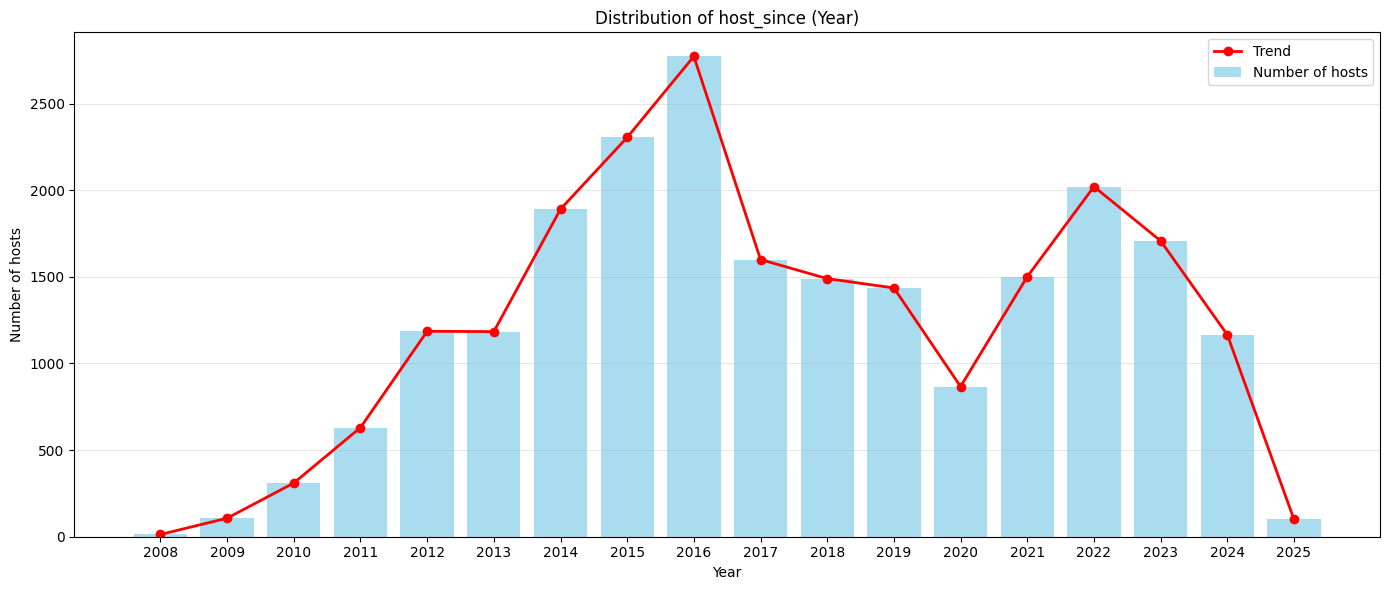

In [131]:
import matplotlib.pyplot as plt

# 연도별로 그룹핑 (2008~2025까지 빈도)
years = range(2008, 2026)
host_counts = df[df['host_since'] > 2000]['host_since'].value_counts().reindex(years, fill_value=0).sort_index()

plt.figure(figsize=(14, 6))

# 히스토그램(막대)
plt.bar(host_counts.index, host_counts.values, color='skyblue', alpha=0.7, label='Number of hosts')

# 꺾은선그래프(라인)
plt.plot(host_counts.index, host_counts.values, color='red', marker='o', linewidth=2, label='Trend')

plt.xlabel('Year')
plt.ylabel('Number of hosts')
plt.title('Distribution of host_since (Year)')
plt.xticks(list(years))  # x축 연도 정수로 모두 표시
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


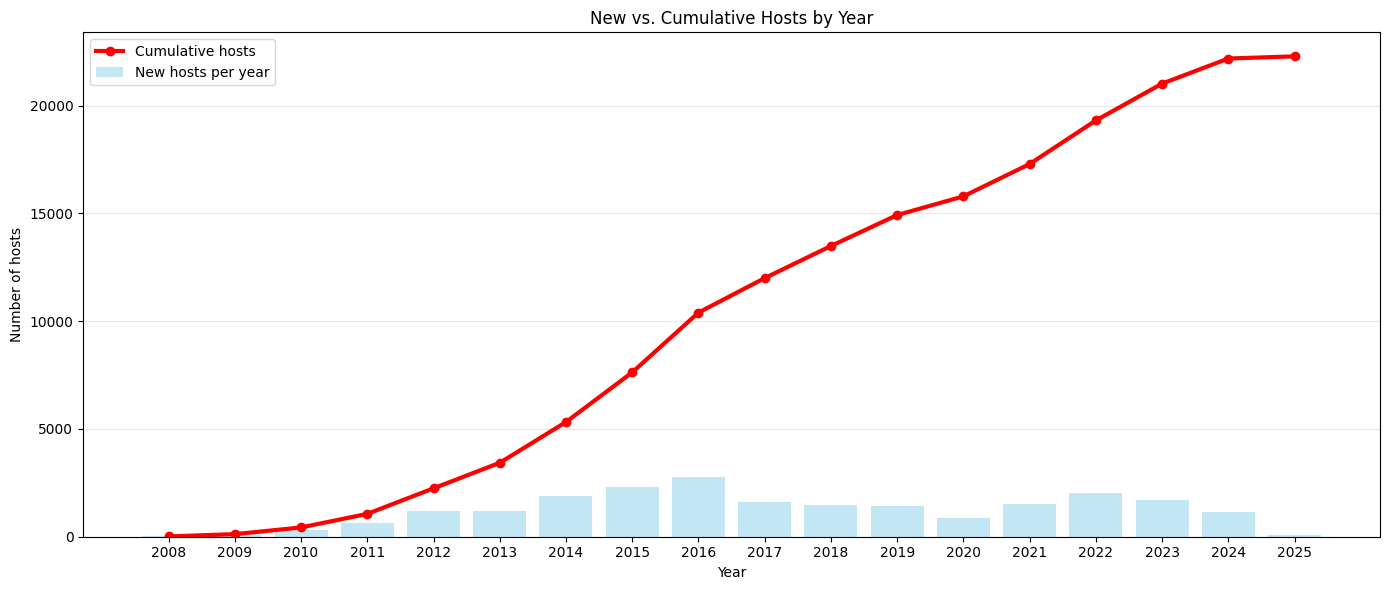

In [132]:
import matplotlib.pyplot as plt

years = range(2008, 2026)
host_counts = df[df['host_since'] > 2000]['host_since'].value_counts().reindex(years, fill_value=0).sort_index()
host_cumsum = host_counts.cumsum()

plt.figure(figsize=(14,6))
plt.bar(host_counts.index, host_counts.values, color='skyblue', alpha=0.5, label='New hosts per year')
plt.plot(host_cumsum.index, host_cumsum.values, color='red', marker='o', linewidth=3, label='Cumulative hosts')

plt.xlabel('Year')
plt.ylabel('Number of hosts')
plt.title('New vs. Cumulative Hosts by Year')
plt.xticks(list(years))
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


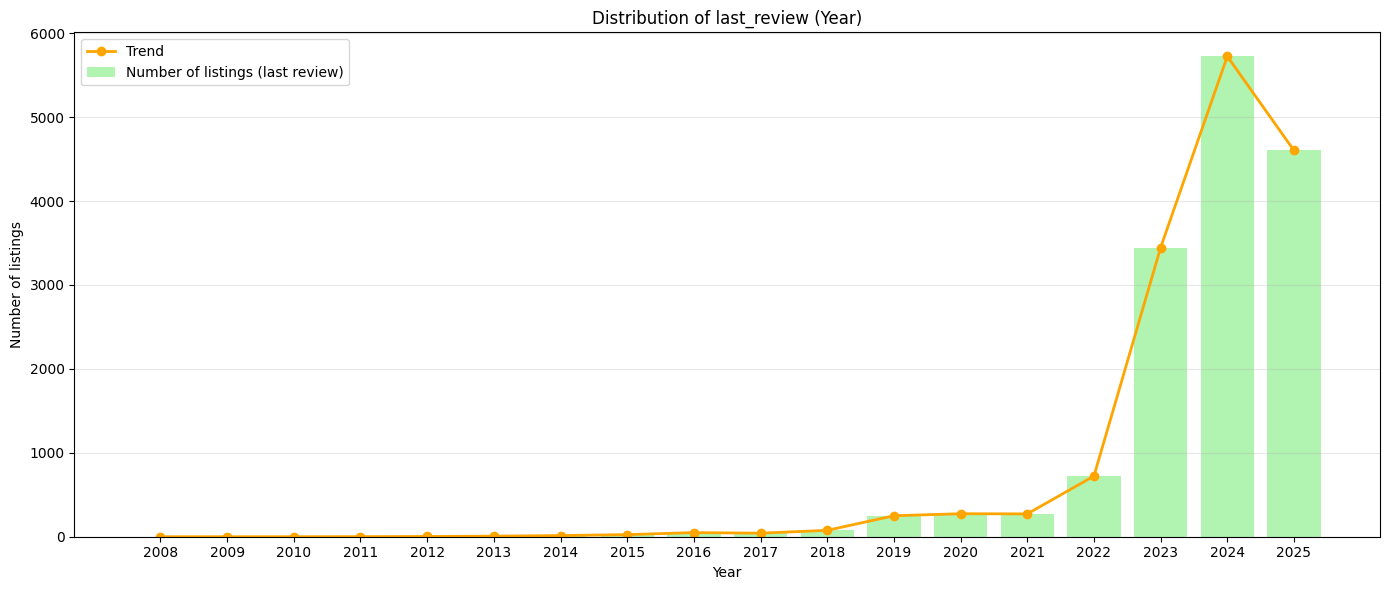

In [133]:
import matplotlib.pyplot as plt

# 연도별로 그룹핑 (2008~2025까지 빈도)
years = range(2008, 2026)
review_counts = df[df['last_review'] > 2000]['last_review'].value_counts().reindex(years, fill_value=0).sort_index()

plt.figure(figsize=(14, 6))

# 히스토그램(막대)
plt.bar(review_counts.index, review_counts.values, color='lightgreen', alpha=0.7, label='Number of listings (last review)')

# 꺾은선그래프(라인)
plt.plot(review_counts.index, review_counts.values, color='orange', marker='o', linewidth=2, label='Trend')

plt.xlabel('Year')
plt.ylabel('Number of listings')
plt.title('Distribution of last_review (Year)')
plt.xticks(list(years))  # x축 연도 정수로 모두 표시
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# last_review 가 대부분 2023년 이후에 있으니, 2022년 이전을 비활성화상태의 숙소로 보는 것이 어떨가

In [ ]:
len(df['last_r'])

In [160]:
(df['last_review'] > 2022).sum()/len(df[df['last_review'] != 0])

np.float64(0.8880722114764668)

In [152]:
((df['last_review'] <= 2022) & (df['last_review'] != 0) & (df['estimated_occupancy_l365d'] == 0)).sum()/len(df)

np.float64(0.07781961628115475)

In [151]:
# 즉 전체 중에 2022년 전이 라스트리뷰(결측치 제외) 0.08 퍼센트 이들을 비활성화 숙소로 봄

In [149]:
(df['number_of_reviews'] == 0).sum()/len(df)

np.float64(0.3047337278106509)

In [155]:
((df['host_since'] <= 2022) & (df['number_of_reviews'] == 0) & (df['estimated_occupancy_l365d'] == 0)).sum()/len(df)

np.float64(0.231083019544558)

In [164]:
df.loc[df['estimated_occupancy_l365d'] == 0].describe()

,id,host_id,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,is_long_term,amenities_cnt,neighborhood_overview_exists,name_length,description_length,host_about_length,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_boolean,host_location_ny,bath_score_mul
count,1.223400e+04,1.223400e+04,12234.000000,12234.000000,12234.000000,12234.000000,12225.000000,12225.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12200.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,1.223400e+04,12234.000000,1.223400e+04,0.0,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.0,12234.0,12234.000000,12234.000000,12234.0,12234.0,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,5436.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.00000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000,12234.000000
mean,6.655381e+17,2.256085e+08,2016.195439,0.926341,0.753511,0.114926,670.711820,823.241145,0.961746,0.914991,40.731055,-73.945244,2.928478,1.243624,1.370082,1.636750,251.330881,32.591875,513.916708,32.429132,56.983897,576.047899,5.272098e+05,33.441009,1.691518e+05,NaN,19.215547,41.424800,64.610103,257.550106,16.156041,0.0,0.0,219.067435,0.021988,0.0,0.0,898.543158,4.706078,4.741103,4.669474,4.822465,4.803206,4.719799,4.601902,0.265571,143.137813,121.778486,17.850172,0.019781,0.564844,0.943273,27.302926,0.516593,35.999019,341.619094,274.30121,3.522969,3.793281,3.381805,0.763446,0.664214,1.097781
std,5.258320e+17,2.064190e+08,54.845784,0.209534,0.297347,0.318945,1611.534508,1872.254954,0.191817,0.278906,0.058101,0.058272,2.196257,0.578161,0.949676,1.198507,555.268027,39.753410,413.547633,39.394714,90.361395,435.906966,3.362565e+07,39.868589,1.855357e+07,NaN,12.921683,23.735968,33.520694,112.856196,43.835188,0.0,0.0,93.808560,0.156362,0.0,0.0,1004.865211,0.333915,0.320470,0.348634,0.271547,0.309741,0.285857,0.368704,0.441655,336.629616,334.196654,74.682197,0.201201,0.743908,0.231330,14.794523,0.499745,10.819665,157.165944,437.57283,0.871544,0.663182,1.039386,0.424983,0.472284,0.593800
min,6.872000e+03,2.787000e+03,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,40.500366,-74.251907,1.000000,0.500000,0.000000,1.000000,8.000000,1.000000,3.000000,1.000000,1.000000,1.000000,3.000000e+00,1.000000,3.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,2.000000,0.000000,0.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.250000
25%,4.583332e+07,3.006509e+07,2015.000000,1.000000,0.610000,0.000000,1.000000,2.000000,1.000000,1.000000,40.688996,-73.982845,2.000000,1.000000,1.000000,1.000000,83.000000,30.000000,270.000000,30.

In [ ]:
# estimated_occupancy_l365 == 0에서 리뷰 없고 리뷰 갯수 영이고 호스트가 2022 년 이전부터 했으면 비활성화로 간주

그럼 총 비활성화 비율이 삼십프로 가량 되는것... 

----

-----

In [123]:
print(df['last_review'].isnull().mean())

0.0


In [124]:
df

,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,is_long_term,amenities_cnt,neighborhood_overview_exists,name_length,name_length_group,description_length,description_length_group,host_about_length,host_about_length_group,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_boolean,host_location_ny,is_shared,is_private,bath_score_mul,structure_type,structure_category
0,36121,city scrape,Lg Rm in Historic Prospect Heights,Cozy space share in the heart of a great neigh...,Full of tree-lined streets and beautiful brown...,62165,Michael,2009,"New York, NY",I’m an urban planner working for an internatio...,NaN,1.00,0.91,0,Prospect Heights,1.0,3.0,"['email', 'phone', 'work_email']",1,1,Neighborhood highlights,Prospect Heights,Brooklyn,40.673760,-73.966110,Private room in rental unit,Private room,1,1.0,1 shared bath,1.0,1,"[Refrigerator, Dishes and silverware, Wifi, Ki...",200.0,90,365,90.0,90.0,365.0,365.0,90.0,365.0,NaN,t,27,57,87,362,2025-03-03,9,0,0,301,0,0,0.0,2010-12-11,2013,4.88,5.00,4.80,5.00,5.00,5.00,5.00,NaN,0,1,0,1,0,0.05,1,7,1,34,short_or_med,215,short_or_avg,291,long,4.0,4,4,1,1,True,False,0.5,rental unit,Residential
1,36647,city scrape,"1 Bedroom & your own Bathroom, Elevator Apartment",Private bedroom with your own bathroom in a 2 ...,"Manhattan, SE corner of 2nd Ave/ E. 110th street",157798,Irene,2010,"New York, NY",NaN,NaN,1.00,1.00,0,East Harlem,1.0,1.0,"['email', 'phone']",1,1,Neighborhood highlights,East Harlem,Manhattan,40.792454,-73.940742,Private room in condo,Private room,2,1.0,1 private bath,1.0,1,"[Oven, Blender, Luggage dropoff allowed, Dedic...",82.0,30,999,30.0,30.0,999.0,999.0,30.0,999.0,NaN,t,0,0,0,204,2025-03-03,102,0,0,143,0,0,0.0,2010-10-04,2023,4.77,4.82,4.76,4.88,4.90,4.38,4.71,NaN,0,1,0,1,0,0.58,1,32,1,49,long,117,short_or_avg,0,empty,4.0,4,4,1,1,False,True,1.0,condo,Residential
2,38663,city scrape,Luxury Brownstone in Boerum Hill,"Beautiful, large home in great hipster neighbo...","diverse, lively, hip, cool: loaded with restau...",165789,Sarah,2010,"New York, NY",I am a lawyer and work as an executive at an a...,within a few hours,1.00,0.40,0,Boerum Hill,1.0,3.0,"['email', 'phone', 'work_email']",1,1,Neighborhood highlights,Boerum Hill,Brooklyn,40.684420,-73.980680,Private room in home,Private room,2,2.5,2.5 baths,5.0,5,"[Portable fans, Oven, Baking sheet, Fire extin...",765.0,3,60,3.0,3.0,60.0,60.0,3.0,60.0,NaN,t,30,49,66,326,2025-03-02,43,0,0,267,0,0,0.0,2012-07-09,2023,4.70,4.83,4.52,4.88,4.88,4.86,4.62,OSE-STRREG-0001784,0,1,0,1,0,0.28,0,68,1,32,short_or_med,84,short_or_avg,99,long,3.0,4,2,1,1,False,True,2.5,home,Residential
3,38833,city scrape,Spectacular West Harlem Garden Apt,This is a very large and uni

In [125]:
non_review['host_since'] = pd.to_datetime(non_review['host_since'], errors='coerce')
non_review['host_since_year'] = non_review['host_since'].dt.year
non_review = non_review.dropna(subset=['host_since_year'])
non_review['host_since_year'] = non_review['host_since_year'].astype(int)

new_pct = (non_review['host_since_year'] >= 2020).sum()/len(non_review)
print(new_pct)

0.44415011037527596


/var/folders/6n/tjcbrygj54s39y61m4r7ymrr0000gq/T/ipykernel_99135/2677149429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_review['host_since'] = pd.to_datetime(non_review['host_since'], errors='coerce')
/var/folders/6n/tjcbrygj54s39y61m4r7ymrr0000gq/T/ipykernel_99135/2677149429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_review['host_since_year'] = non_review['host_since'].dt.year


In [126]:
df['host_since'].isnull().sum()

np.int64(0)

In [127]:
non_review.loc[non_review['host_since'].isnull()]

,id,source,name,description,neighborhood_overview,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,is_long_term,amenities_cnt,neighborhood_overview_exists,name_length,name_length_group,description_length,description_length_group,host_about_length,host_about_length_group,host_response_time_score,host_response_rate_score,host_acceptance_rate_score,host_location_boolean,host_location_ny,is_shared,is_private,bath_score_mul,structure_type,structure_category,host_since_year


그럼 인사이트는 리뷰가 없는게 전체의 30%고 이 중에서 결측치가 단 3개 뿐 나머지값들도 결측치가 많아서 이거 삭제한다 치고, 남은 것들 중 45퍼센트 가량이 host_since_year로 보았을 때, 2020년 이후 신규 호스트들 > 즉 신규로 분류



In [135]:
df.to_csv('jiwon_proprocessing_df.csv', index=False)

In [137]:
df['availability_365'].isnull().sum()

np.int64(0)

In [140]:
(df['number_of_reviews_ly']==0).sum()/len(df)

np.float64(0.5555406132329209)

In [141]:
(df['number_of_reviews']==0).sum()/len(df)

np.float64(0.3047337278106509)

In [ ]:
# Last review가 2022년 이전으로 잡아도 괜챃을지.
# host_since가 2022년 이후면 신규(활성화)상태 

In [166]:
cond1 = (df['last_review'] <= 2022) & (df['last_review'] != 0) & (df['estimated_occupancy_l365d'] == 0)
cond2 = (df['host_since'] <= 2022) & (df['number_of_reviews'] == 0) & (df['estimated_occupancy_l365d'] == 0)

df['is_activate'] = np.select([cond1, cond2], [0, 0], default=1)

In [169]:
(df['is_activate'] == 0).sum()/len(df)

np.float64(0.30890263582571276)